## Network Transfer Function: Usage example

![](./classes.png)

### Import modules with respective paths

In [2]:
import sys
sys.path.append("..")

#SCFC modules
from forward import network_transfer as nt
from utils import path
from utils import functions
from brain import brain

#generic modules
import matplotlib.pyplot as mpl
import numpy as np
from scipy.signal import lfilter, firls, decimate
import time

### Create new `Brain()` and populate it

Let us first set up a `Brain()` and its attributes: `connectome`, `ordering`, and `ntf_params`

In [3]:
new_brain = brain.Brain()

hcp_dir = path.get_data_path() # connectome information is in /data/ dir
new_brain.set_hcp_connectome(hcp_dir) # Use default files in /data/

Let's see what the attributes of brain are:

In [4]:
vars(new_brain).keys()

dict_keys(['Cdk_conn', 'reducedC', 'Ddk_conn', 'permHCP', 'ordering', 'ntf_params'])

And which have been initialized, so far

In [5]:
vars(new_brain)

{'Cdk_conn': array([[0.0000e+00, 1.2500e-01, 3.1500e+00, ..., 0.0000e+00, 0.0000e+00,
         4.8750e-01],
        [1.2500e-01, 0.0000e+00, 2.3750e-01, ..., 0.0000e+00, 7.8750e-01,
         6.2500e-02],
        [3.1500e+00, 2.3750e-01, 0.0000e+00, ..., 0.0000e+00, 2.5000e-02,
         8.2500e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 9.1250e-01,
         5.3087e+01],
        [0.0000e+00, 7.8750e-01, 2.5000e-02, ..., 9.1250e-01, 0.0000e+00,
         2.2050e+01],
        [4.8750e-01, 6.2500e-02, 8.2500e-01, ..., 5.3087e+01, 2.2050e+01,
         0.0000e+00]]),
 'reducedC': None,
 'Ddk_conn': array([[ 0.    ,  6.7149, 60.525 , ...,  0.    ,  0.    , 23.653 ],
        [ 6.7149,  0.    ,  9.3809, ...,  0.    , 18.139 ,  3.0703],
        [60.525 ,  9.3809,  0.    , ...,  0.    ,  1.0898, 48.488 ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  4.9372,  9.5358],
        [ 0.    , 18.139 ,  1.0898, ...,  4.9372,  0.    ,  4.0963],
        

We have the connectome (`Cdk_conn`), the distance matrix (`Ddk_conn`), the permanent hcp ordering (`permHCP`), and some defaul parameters for the `network_transfer_function` (`ntf_params`).

Now, the `network_transfer_function` has 4 input parameters:
- `C`: the **reduced** connectivity matrix
- `D`: the distance matrix
- `parameters`: the 7 ntf parameters
- `w`: the frequency at which the ntf will be calculated at.
    
We have all but the first parameter since we need to convert the connectivity matrix to a **reduced** form. This is done by applying 2 functions to the `new_brain`:
- `new_brain.bi_symmetric_c()`
- `new_brain.reduce_extreme_dir()`

In [6]:
# Make aliases for new_brain attributes for easier manipulation
Cdk_conn = new_brain.Cdk_conn
Ddk_conn = new_brain.Ddk_conn
perm_HCP = new_brain.permHCP
default_ntf_params = new_brain.ntf_params

# Some other ordering that was in the original code:
linds = np.concatenate([np.arange(0,34), np.arange(68,77)])
rinds = np.concatenate([np.arange(34,68), np.arange(77,86)])

q = np.maximum(Cdk_conn[linds,:][:,linds], Cdk_conn[rinds,:][:,rinds])
q1 = np.maximum(Cdk_conn[linds,:][:,rinds], Cdk_conn[rinds,:][:,linds])

# Calculate the reduced form for Cdk_conn
new_brain.bi_symmetric_c(linds, rinds)
new_brain.reduce_extreme_dir(Cdk_conn)

# Make an alias for the reduced form of Cdk_conn
C = new_brain.reducedC

# Finally: calculate the network_transfer_function for a frequency w = 2PI
fq, ev, Vv, freqresp_out, _ = nt.network_transfer_function(C=C, 
                                                           D=Ddk_conn, 
                                                           parameters = default_ntf_params, 
                                                           w=2*np.pi)

### Calculating network transfer function for a *range* of frequencies

Now loop over a range of frequencies of interest and calculate the `ntf`.

1. First setup such frequencies:

In [7]:
fs = 600 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
fvec = np.linspace(fmin,fmax,40)
hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 100])*2/fs,
           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)
ind_del = hbp.size #number of coefficients in hbp. Delete that number in beginning of signal due to filtering

/Users/pferreira/.virtualenvs/py36-brain/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


2. Then calculate the frequency response:

In [8]:
# Compute for all frequencies in fvec - this is the debug part in Ashish's SCFC_onJuliaMEG3.m
#freqresp = []

evec = []
Vvec =[]
fqall = []
freq_model = []

start = time.time()
for i in fvec:
    w = 2*np.pi*i
    fq, ev, Vv, freqresp_out, _ = nt.network_transfer_function(C, Ddk_conn, default_ntf_params, w)
    fqall.append(fq)
    evec.append(ev)
    Vvec.append(Vv)
    freq_model.append(freqresp_out)
    
fqall=np.asarray(fqall)
evec = np.asarray(evec)
Vvec = np.asarray(Vvec)
freq_model = np.asarray(freq_model)
freq_model = np.transpose(freq_model)
stop = time.time()
duration = stop - start

print('Computation time = ', duration)
# np.moveaxis(Vvec,1,0).shape #86x40x57 just like matlab

Computation time =  0.45499181747436523


### Plotting: first eigen values, eigen vectors, and their frequency responses

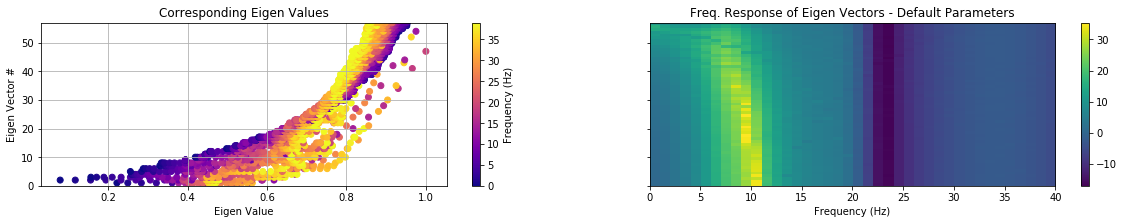

In [9]:
# Plotting eigen values of each eigen vector
#mpl.figure(num=5)
cmap = mpl.get_cmap('plasma')
fig_ev, ax_ev = mpl.subplots(1,2, figsize = (20,3), sharey = True)
for i in np.arange(0,evec.shape[1]):
    fig0=ax_ev[0].scatter(np.abs(evec[:,i]), np.ones(evec.shape[0])*(i+1), c = np.arange(0,fvec.size), cmap = cmap)
    
ax_ev[0].grid(True)
clb = fig_ev.colorbar(fig0, ax=ax_ev[0])
ax_ev[0].set_xlabel('Eigen Value')
ax_ev[0].set_ylabel('Eigen Vector #')
ax_ev[0].set_title('Corresponding Eigen Values')
clb.ax.set_ylabel('Frequency (Hz)')
#mpl.savefig('ev_Vv_plot.png', dpi = 300, format = 'png')

# Plotting eigen vector's frequency response with default parameters
ev_freqresp = np.abs(np.transpose(fqall))
#fig_ev, ax_ev = mpl.subplots()
ax1=ax_ev[1].imshow(functions.mag2db(np.abs(ev_freqresp)), extent = [0, 40, 0, 57], aspect='auto')
#fig_ev.colorbar(ax1)
ax_ev[1].set_title('Freq. Response of Eigen Vectors - Default Parameters')
ax_ev[1].set_xlabel('Frequency (Hz)')
fig_ev.colorbar(ax1)
#mpl.savefig('freqresp_eigs_default.png', dpi = 300, format = 'png')

### Plotting Magnitudes

Text(0, 0.5, 'Magnitude (dB)')

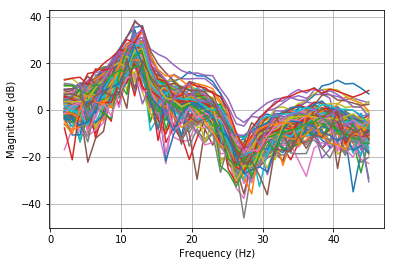

In [10]:
fig = mpl.figure(num=5, figsize = (6,4))
for g in range(len(freq_model)):
    mpl.plot(fvec,functions.mag2db(np.abs(freq_model[g,:])))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')
#mpl.plot(fvec,mag2db(np.abs(freq_model)))